In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interactive
%matplotlib inline
import seaborn as sns

In [2]:
from tqdm import tqdm
from collections import defaultdict

In [3]:
import ipywidgets as widgets
from ipywidgets import HBox, VBox
from IPython.display import display


In [4]:
train_df = pd.read_csv('../data/train_users.csv')
test_df = pd.read_csv('../data/test_users.csv')

In [5]:
users = pd.concat([train_df.drop('country_destination', axis = 1), test_df], axis = 0, ignore_index = True)

In [6]:
date_account_created = pd.DatetimeIndex(users.date_account_created)
users['account_created_year'] = date_account_created.year
users['account_created_month'] = date_account_created.month
users['account_created_day'] = date_account_created.day
users['account_created_weekday'] = date_account_created.weekday

In [7]:
sessions = pd.read_csv('../data/sessions_expanded.csv')

In [8]:
"""
sessions = sessions.rename(columns = {'user_id':'id'})
sessions = sessions.dropna(subset = ['id'])
sessions['secs_elapsed'] = sessions['secs_elapsed'].fillna(0)

sessions_ids = sessions.id.unique()
from_train = train_df.loc[train_df.id.isin(sessions_ids), ['id', 'date_account_created']]
from_test = test_df.loc[test_df.id.isin(sessions_ids), ['id', 'date_account_created']]
account_created_date = pd.concat([from_train, from_test], axis = 0)

sessions['cumulate_secs'] = sessions.groupby('id')['secs_elapsed'].cumsum()
sessions['cumulate_days'] = sessions['cumulate_secs']/60/60//24

account_date = defaultdict()
for _id, _date in zip(account_created_date['id'], account_created_date['date_account_created']):
    account_date[_id] = pd.to_datetime(_date)
    
def return_session_date(row):
    _id = row['id']
    _delta = row['cumulate_days']
    
    return account_date[_id] + pd.DateOffset(_delta)

tqdm.pandas()
sessions['session_date'] = sessions.loc[:, ['id', 'cumulate_days']].progress_apply(return_session_date, axis = 1)
"""

"\nsessions = sessions.rename(columns = {'user_id':'id'})\nsessions = sessions.dropna(subset = ['id'])\nsessions['secs_elapsed'] = sessions['secs_elapsed'].fillna(0)\n\nsessions_ids = sessions.id.unique()\nfrom_train = train_df.loc[train_df.id.isin(sessions_ids), ['id', 'date_account_created']]\nfrom_test = test_df.loc[test_df.id.isin(sessions_ids), ['id', 'date_account_created']]\naccount_created_date = pd.concat([from_train, from_test], axis = 0)\n\nsessions['cumulate_secs'] = sessions.groupby('id')['secs_elapsed'].cumsum()\nsessions['cumulate_days'] = sessions['cumulate_secs']/60/60//24\n\naccount_date = defaultdict()\nfor _id, _date in zip(account_created_date['id'], account_created_date['date_account_created']):\n    account_date[_id] = pd.to_datetime(_date)\n    \ndef return_session_date(row):\n    _id = row['id']\n    _delta = row['cumulate_days']\n    \n    return account_date[_id] + pd.DateOffset(_delta)\n\ntqdm.pandas()\nsessions['session_date'] = sessions.loc[:, ['id', 'cumu

In [9]:
sessions.head(4)

,Unnamed: 0,id,action,action_type,action_detail,device_type,secs_elapsed,cumulate_secs,cumulate_days,session_date
0,0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0,319.0,0.0,2014-01-01
1,1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0,68072.0,0.0,2014-01-01
2,2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0,68373.0,0.0,2014-01-01
3,3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0,90514.0,1.0,2014-01-02


In [10]:
@widgets.interact(year = (2010, 2014))
def date(year=2010):
    data = users.loc[users.account_created_year == year]
    x = data['account_created_month'].unique()
    y = data.account_created_month.value_counts().sort_index()
    plt.figure(figsize = (12, 8))
    plt.plot(y)
    plt.xticks(x)
    plt.ylim(0, 24000)
    plt.grid(alpha = 0.3)

interactive(children=(IntSlider(value=2010, description='year', max=2014, min=2010), Output()), _dom_classes=(…

In [11]:
columns = ['account_created_year', 'account_created_month']
range_slider = widgets.SelectionRangeSlider(
    options = ['{}-{:02}'.format(y, m) for (y, m) in users[columns].groupby(columns).agg(len).index],
    index = (0, 11),
    disabled = False,
    layout={'width': '500px'},
    description='Dates'
)

In [12]:
range_slider

SelectionRangeSlider(description='Dates', index=(0, 11), layout=Layout(width='500px'), options=('2010-01', '20…

In [13]:
def return_selected_range(start, end):

    start = pd.to_datetime(start, format = '%Y-%m')
    end = pd.to_datetime(end, format = '%Y-%m')
    
    date_mask = (pd.to_datetime(users.date_account_created) >= start) & (pd.to_datetime(users.date_account_created) <= end)
    return users.loc[date_mask]
def print_date_range(date_range):
    
    start = date_range[0]
    end = date_range[1]
    
    data = return_selected_range(start, end)
    columns = ['account_created_year', 'account_created_month']
    y = data[columns].groupby(columns).agg(len)
    x = ['{}-{:02}'.format(year, month) for (year, month) in y.index]
    plt.figure(figsize = (16, 8))
    plt.bar(x, y)
    plt.xticks(rotation = 90)
    plt.show()
    
widgets.interact(
    print_date_range,
    date_range=range_slider
);

interactive(children=(SelectionRangeSlider(description='Dates', index=(0, 11), layout=Layout(width='500px'), o…

In [14]:
month_select = widgets.SelectionSlider(
    options= ['{}-{:02}'.format(y, m) for (y, m) in users[columns].groupby(columns).agg(len).index],
    #value='sunny side up',
    description='Select Month',
    disabled=False,
    continuous_update = False,
    orientation='horizontal',
    readout=True
)

In [27]:
def return_new_account(year, month):

    year_mask = users.account_created_year == year
    month_mask = users.account_created_month == month
    
    return users.loc[year_mask & month_mask]

In [26]:
def return_new_booking(year, month):

    booked = pd.DatetimeIndex(users.date_first_booking)
    year_mask = booked.year == year
    month_mask = booked.month == month
    
    return users.loc[year_mask & month_mask]

In [17]:
def return_previous_month(year, month, previous = 1):
    
    if previous >= 12:
        year -= previous // 12
    
    if month - (previous % 12) < 1:
        year -= 1
        month += 12
        
    month -= previous % 12
    
    return (year, month)

In [18]:
def return_affiliate_channel_data(year, month):
    
    channels = {channel: 0 for channel in users.affiliate_channel.unique()}
    
    year_mask = users.account_created_year == year
    month_mask = users.account_created_month == month
    
    counts = users.loc[year_mask & month_mask, 'affiliate_channel'].value_counts()
    for channel, count in counts.items():
        channels[channel] = count

    return channels

In [19]:
def draw_bar_plot(x, y, figsize = (16, 8)):
    plt.figure(figsize = figsize)
    #plt.bar(x, y)
    sns.barplot(x, y)
    plt.grid(alpha = 0.3)
    plt.labels = x
    plt.show()

In [20]:
#@datetime_decorator
def draw_line_plot(x, y, figsize = (16, 8)):
    plt.figure(figsize = figsize)
    plt.plot(x, y)
    plt.grid(alpha = 0.3)
    plt.show()
    return plt

In [21]:
def collect_last_three_month_account(year, month):
    
    periods = []
    counts = []
    for previous in range(2, -1, -1):
        y, m = return_previous_month(year, month, previous)
        counts.append(return_new_account(y, m))
        periods.append('{}-{:02}'.format(y, m))
    
    return (periods, counts)

In [22]:
#@datetime_decorator
def collect_last_three_month_channel(year, month):
    
    periods = []
    counts = []
    
    for previous in range(2, -1, -1):

        y, m = return_previous_month(year, month, previous)
        counts.append(return_affiliate_channel_data(y, m))
        periods.append('{}-{:02}'.format(y, m))
    
    return (periods, counts)    

In [28]:
def display_monthly(date):
    
    (year, month) = map(int, date.split('-'))
    
    periods, counts = collect_last_three_month_account(year, month)
    
    current_month_new_users = len(return_new_account(year, month))
    current_month_new_bookings = len(return_new_booking(year, month))
    
    print('New Account : ', len(current_month_new_users))
    print('New First Booking : ', len(current_month_new_bookings))
    draw_line_plot(periods, counts, (12,6))
    
    last_year, last_month = return_previous_month(year, month)
    last_month_new_users = return_new_account(last_year, last_month)
    last_month_new_bookings = return_new_booking(last_year, last_month)
    
    try:
        print('Account Growth Rate : {:03.4f}'.format(len(current_month_new_users) / len(last_month_new_users)))
        print('Booking Growth Rate : {:03.4f}'.format(len(current_month_new_bookings) / len(last_month_new_bookings)))
    except ZeroDivisionError as error:
        print('Account Growth Rate : ', 0)
        print('Booking Growth Rate : ', 0)
    
    # Affiliate Channel
    periods, counts = collect_last_three_month_channel(year, month)
    data = pd.DataFrame(counts, index = periods).reset_index()
    data = pd.melt(data, id_vars = 'index', var_name = 'channel', value_name = 'count')
    plt.figure(figsize = (12,6))
    sns.barplot(x = 'channel', hue = 'index',  y = 'count', data = data)
    plt.grid(alpha = 0.3)
    plt.show()
    
    
    # Destination
    users.

SyntaxError: invalid syntax (<ipython-input-28-24b48e4a6a66>, line 36)

interactive(children=(SelectionSlider(continuous_update=False, description='Select Month', index=33, options=(…

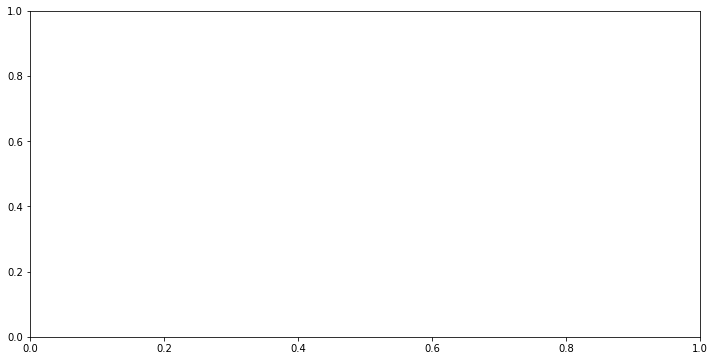

In [29]:
widgets.interact(
    display_monthly,
    date = month_select
);

In [25]:
def datetime_decorator(func):

    def wrapper(*args, **kwargs):
        
        print(func.__name__, datetime.datetime.now())
        date = func(*args, **kwargs)
        print(func.__name__, datetime.datetime.now())
        return date
    return wrapper


In [37]:
_input = {'Bedroom': [3], 'Space': [1500], 'Room': [8], 'Lot': [40], 'Tax': [1000], 'Bathroom': [2], 'Garage':[1], 'Condition': [0]}
        
predict_data = np.array([3, 1500, 8, 40, 1000, 2, 1, 0])

In [38]:
pd.DataFrame.from_dict(_input)

,Bedroom,Space,Room,Lot,Tax,Bathroom,Garage,Condition
0,3,1500,8,40,1000,2,1,0


In [40]:
t='(1970-2014)'

In [46]:
t.split('(')[1].split('-')[0]

'1970'

In [ ]:
def squared(s):
  return s * s
spark.udf.register("squaredWithPython", squared)